Just starting to think about how I can do this. 

# Collecting Stats From Previously Gathered Data

### Importing Libraries

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import sys


In [90]:
def returnFullSeasonStats(teamName, yearArr):
    """
    Goes into stats folder and reads in the both stats and Info csv files
    Concats them into a single data frame and returns them.

    Args:
        teamName (string): the team name matching the name within Stats File
        yearArr (array of ints): Allows to make sure we can pull specific year ranges
    Returns:
        TeamPDStats: Pandas Data-Frame of team game stats from all seasons collected
        teamPDInfo: Pandas Data-Frame of game info from all seasons collected
    """
    #data frame holding things like total yards for every season collected
    teamPDStats = pd.DataFrame()
    #data frame holding things like weather for every game in every season collected
    teamPDInfo = pd.DataFrame()
    #gets all csv files for a team
    dirList = os.listdir(f"Stats/{teamName}/")
    for file in dirList:
        if(int(file[-8:-4]) not in yearArr):
            continue
        #if stats then --> else, it is the game info. 
        if "Stats" in file:
            curr = pd.read_csv(f"Stats/{teamName}/{file}")
            teamPDStats = pd.concat([teamPDStats, curr],axis = 0)
        else:
            curr = pd.read_csv(f"Stats/{teamName}/{file}")
            teamPDInfo = pd.concat([teamPDInfo, curr],axis = 0)
    #returns the collected, concected pds. 
    return teamPDStats, teamPDInfo
 
def returnSpecificRow(teamDataFrame, statName):
    """
    Pulls specifc rows from a given dataframe with given stat name

    Args:
        statName (string): the name of stat within the dataframe
        teamDataFrame (Pandas Data Fram): Passed dataframe containing all of the
    Returns:
        statPD: Dataframe of row querried for
    """
    statPD = pd.DataFrame(teamDataFrame.loc[teamDataFrame["Unnamed: 1"].str.lower() == statName.lower(), teamDataFrame.columns[2]: teamDataFrame.columns[-1]].values.flatten())
    return statPD

def extractNumberFromString(givenString):
    """
    Extracts a float from a string with a format. Requires this number to have a decimal point

    Args:
        givenString (string): string with number inside
    Returns:
        extractedFloat (float): the extracted number within the string
    """
    extractedFloat = givenString.extract(r"(\d+\.\d*)").astype(float)
    return extractedFloat

def getSpreadandScores(currFullSeasonStats, currFullSeasonInfo, currTeam):
    #3 letter abbrivation 
    teamAbbr = currFullSeasonStats["Unnamed: 0"][0]

    #geting team scores and opp scores
    teamsScore = returnSpecificRow(currFullSeasonStats, f"{teamAbbr} Score")
    opponentScore = returnSpecificRow(currFullSeasonStats, "Opp Score")
    
    #[2:] and on to exclude the label and empty column
    #getting total score
    teamScoreFloat = teamsScore[0][2:].astype(float) 
    oppScoreFloat = opponentScore[0][2:].astype(float)
    #getting actual spread
    scoreDifference = pd.DataFrame(teamScoreFloat - oppScoreFloat)
    
    #getting vegas over under
    overUnder = returnSpecificRow(currFullSeasonInfo, "Over/Under")

    #getting vegas spread
    spread = returnSpecificRow(currFullSeasonInfo, "Vegas Line")

    
    #This takes the pandas array, with info like "45.5 (over)" and takes just the number
    #extract takes a regular exprexsion (regex) "\d" grabs number before decimal place
    #"/.?" grabs the the decimal point and "\d*" grabs the post decimal place. 
    #() tells .extract to only take what is in the parentheses until white space.
    overUnderNumber = extractNumberFromString(overUnder[0].str)
    spreadNumber =  extractNumberFromString(spread[0].str)

    #takes out nan and label rows
    overUnderNumber = overUnderNumber[2:]
    vegasSpread = spreadNumber[2:]
    #convering spread to be in format as vegas. 
    for i in range(1,len(scoreDifference)):
        if ("nan" not in str(spread[0][i])) and currTeam not in spread[0][i]:
            #if broncos were favored then switch there real spread to reflect they won
            #locate the row i in first column make it negative. 
            vegasSpread.iloc[i, 0] = -1 * vegasSpread.iloc[i, 0]

    teamBeatSpread = scoreDifference[:] - vegasSpread[:]
    
    return teamBeatSpread, scoreDifference, vegasSpread, teamScoreFloat, oppScoreFloat


In [91]:
#directory where Stats was stored
directory = 'Stats/'

yearArr = [2017]

#array of each directory within stats
TeamNamesArr= os.listdir(directory)

for team in TeamNamesArr:
    if team == ".DS_Store":
        continue
    currFullSeasonStats, currFullSeasonInfo = returnFullSeasonStats(team, yearArr)
    teamBeatSpread, scoreDifference, vegasSpread, teamScoreFloat, oppScoreFloat = getSpreadandScores(currFullSeasonStats, currFullSeasonInfo, team)
    break



/var/folders/xn/xm07qqqx6q93rm93tp51mjvh0000gn/T/ipykernel_60889/2649063048.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegasSpread.iloc[i, 0] = -1 * vegasSpread.iloc[i, 0]


## When the actual spread wins, it means the current team of interest beat the spread

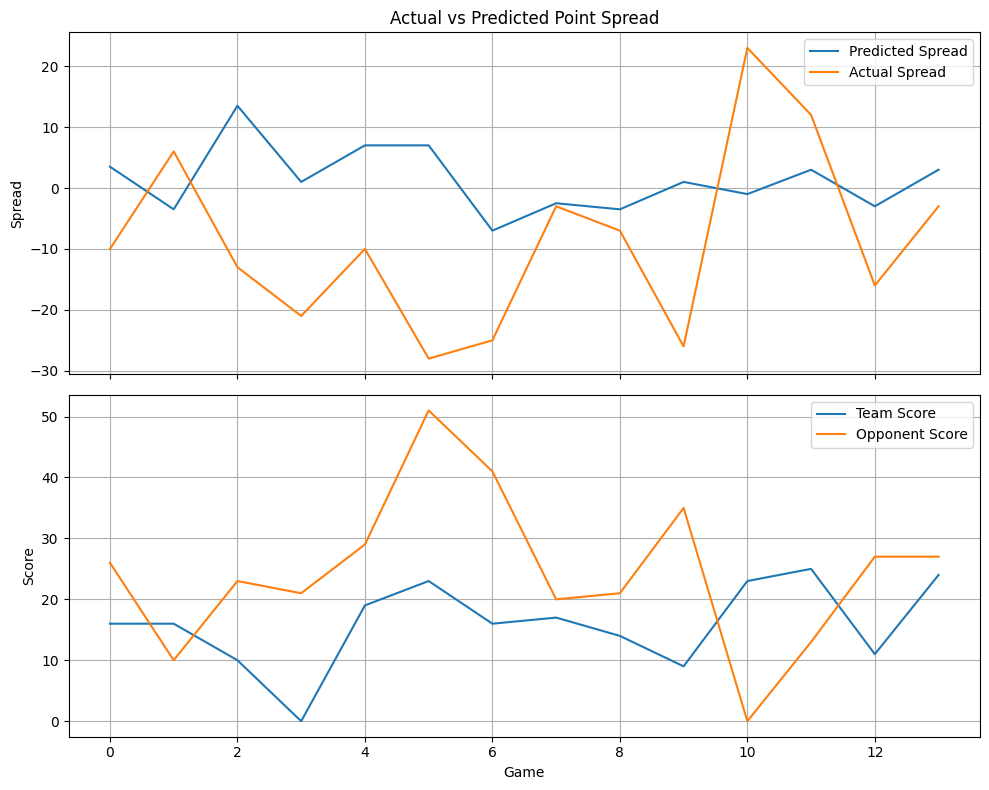

In [92]:
gamerange = np.arange(len(vegasSpread))
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
# Top subplot: spreads
axs[0].plot(gamerange, vegasSpread, label="Predicted Spread")
axs[0].plot(gamerange, scoreDifference, label="Actual Spread")
axs[0].set_ylabel("Spread")
axs[0].set_title("Actual vs Predicted Point Spread")
axs[0].grid(True)
axs[0].legend()

# Bottom subplot: scores
axs[1].plot(gamerange, teamScoreFloat, label="Team Score")
axs[1].plot(gamerange, oppScoreFloat, label="Opponent Score")
axs[1].set_xlabel("Game")
axs[1].set_ylabel("Score")
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()


In [93]:
teamBeatSpread = scoreDifference[:] - vegasSpread[:]


In [95]:
# print(scoreDifference)
# vegasSpread
teamBeatSpread

,0
2,-13.5
3,9.5
4,-26.5
5,-22.0
6,-17.0
7,-35.0
8,-18.0
9,-0.5
10,-3.5
11,-27.0


In [55]:
#directory where Stats was stored
directory = 'Stats/'

yearArr = [2019,2020]

#array of each directory within stats
TeamNamesArr= os.listdir(directory)

for team in TeamNamesArr:
    if team == ".DS_Store":
        continue
    currFullSeasonStats, currFullSeasonInfo = returnFullSeasonStats(team, yearArr)
    
    #3 letter abbrivation 
    teamAbbr = currFullSeasonStats["Unnamed: 0"][0]
    #geting team scores and opp scores
    teamsScore = returnSpecificRow(currFullSeasonStats, f"{teamAbbr} Score")
    opponentScore = returnSpecificRow(currFullSeasonStats, "Opp Score")

    #[2:] and on to exclude the label and empty column
    #getting total score
    totalScore = teamsScore[0][2:].astype(float) + opponentScore[0][2:].astype(float)

    #getting actual spread
    realSpread = teamsScore[0][2:].astype(float) - opponentScore[0][2:].astype(float)
    
    #getting vegas over under
    overUnder = returnSpecificRow(currFullSeasonInfo, "Over/Under")

    #getting vegas spread
    spread = returnSpecificRow(currFullSeasonInfo, "Vegas Line")

    
    #This takes the pandas array, with info like "45.5 (over)" and takes just the number
    #extract takes a regular exprexsion (regex) "\d" grabs number before decimal place
    #"/.?" grabs the the decimal point and "\d*" grabs the post decimal place. 
    #() tells .extract to only take what is in the parentheses until white space.
    
    overUnderNumber = extractNumberFromString(overUnder[0].str)
    spreadNumber =  extractNumberFromString(spread[0].str)

    #takes out nan and label rows
    overUnderNumber = overUnderNumber[2:]
    spreadNumber = spreadNumber[2:]
    #convering spread to be in format as vegas. 
    for i in range(1,len(realSpread)):
        if ("nan" not in str(spread[0][i])) and team not in spread[0][i]:
            #if broncos were favored then switch there real spread to reflect they won
            #locate the row i in first column make it negative. 
            spreadNumber.iloc[i, 0] = -1 * spreadNumber.iloc[i, 0]


    currBeatSpread = realSpread - spreadNumber
    break

In [57]:
teamsScore

,0
